This file will cover everything in Milestone 4. 

First is calculating the loss. This is done by finding which loans were a loss to the company, and calculating how much of the loan was actually paid back. As mentioned previously, I will be using the copy of the dataset from before I applied any skew transformations on the columns, as this would alter the data too much.

In [2]:
import pandas as pd

df = pd.read_csv('nulls_removed.csv')

# Get the number of entries that are Charged Off
charged_off_count = df['loan_status'].str.strip().str.lower().value_counts().get('charged off', 0)

# Get the total number of entries in the column
tot = len(df['loan_status'])

percentage = charged_off_count / tot * 100

print(f"Percentage of loans 'Charged Off' = {percentage:.2f}%")

Percentage of loans 'Charged Off' = 10.05%


So we can see about 10% of loans are charged off in the data set. To find the total amount that was paid towards these loans, we have to find the corresponding funded_amount for the row, if the status is charged off, and sum the total value.

In [3]:
charged_off_payments = df[df['loan_status'] == 'Charged Off']['funded_amount']

total_payments = charged_off_payments.sum()

print(f"The total amount paid off towards the loans before being charged off is £{total_payments:,}")

The total amount paid off towards the loans before being charged off is £66,884,375.0


Now, we can look at the projected loss from these loans, i.e how much the company would have made if these loans were paid off in full.

In [4]:
charged_off_loans = df[df['loan_status'] == 'Charged Off']['loan_amount']

total_loans = charged_off_loans.sum()
loss = total_loans - total_payments

print(f"The total value of the loans is £{total_loans:,}")
print(f"This means the total loss is £{loss:,}")

The total value of the loans is £68,188,000.0
This means the total loss is £1,303,625.0


We can visualize this loss by looking at the remaining term of these loans.

In [5]:
import matplotlib.pyplot as plt

# Find the term remaining for charged off loans

charged_off = df[df['loan_status'] == 'Charged Off'].copy()

# Find out how many months have passed between the issue date and the last payment date

charged_off['issue_date'] = pd.to_datetime(charged_off['issue_date'])
charged_off['last_payment_date'] = pd.to_datetime(charged_off['last_payment_date'])

charged_off.loc[:, 'months_passed'] = (charged_off['last_payment_date'] - charged_off['issue_date']).dt.days // 30

charged_off['remaining_term'] = charged_off['term'] - charged_off['months_passed']

charged_off.head(5)

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type,missing,months_passed,remaining_term
52,38654836,41438603,11200.0,11200.0,11200.0,60.0,16.49,275.29,D,D3,...,0.0000,2021-08-01,275.29,2022-01-01,0.0,1,INDIVIDUAL,False,7,53.0
79,38645937,41429742,1325.0,1325.0,1325.0,36.0,17.14,47.34,D,D4,...,0.0000,2021-07-01,47.34,2022-01-01,0.0,1,INDIVIDUAL,False,6,30.0
85,38645713,41429516,8150.0,8150.0,8150.0,36.0,19.99,302.85,E,E3,...,0.0000,2021-07-01,302.85,2021-12-01,0.0,1,INDIVIDUAL,False,6,30.0
109,38644867,41428644,7000.0,7000.0,7000.0,36.0,12.99,235.83,C,C2,...,214.6644,2021-03-01,235.83,2021-08-01,0.0,1,INDIVIDUAL,False,1,35.0
129,38644180,41427896,14000.0,12000.0,14000.0,36.0,7.49,435.43,A,A4,...,0.0000,2021-04-01,435.43,2022-01-01,0.0,1,INDIVIDUAL,False,3,33.0


Now we need to visualize this in a meaningful way. The best way to do this is to have two lines showing the cumulative frequency. One is where the loans are payed off, and one is where the loans have not been paid off, as in the dataset.

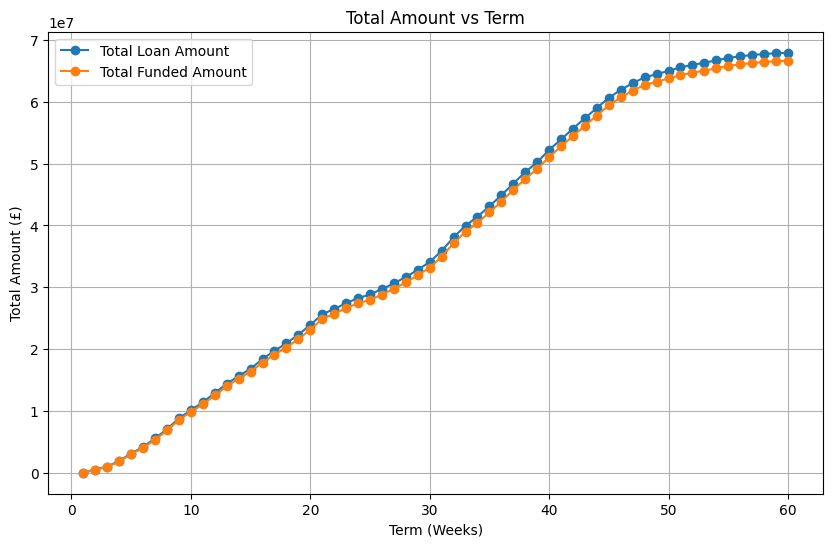

In [6]:
# Calculate cumulative frequency for loan amount
charged_off['cumulative_frequency_loan_amount'] = charged_off['loan_amount'].cumsum()

# Calculate cumulative frequency for funded amount
charged_off['cumulative_frequency_funded_amount'] = charged_off['funded_amount'].cumsum()

terms = list(range(1, 61))
total_loan_amount = []
total_funded_amount = []

for term in terms:
    term_df = charged_off[charged_off['remaining_term'] >= term]
    
    if not term_df.empty:
        total_loan_amount.append(term_df['loan_amount'].sum())
        total_funded_amount.append(term_df['funded_amount'].sum())
    else:
        total_loan_amount.append(0)
        total_funded_amount.append(0)

total_loan_amount = total_loan_amount[::-1]
total_funded_amount = total_funded_amount[::-1]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(terms, total_loan_amount, label='Total Loan Amount', marker='o')
plt.plot(terms, total_funded_amount, label='Total Funded Amount', marker='o')

plt.title('Total Amount vs Term')
plt.xlabel('Term (Weeks)')
plt.ylabel('Total Amount (£)')
plt.legend()
plt.grid(True)
plt.show()


Next, we can look at the possible loss. This means we have to look at the number of late entries in the loan_status column:

In [7]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             24666
Current                                                17612
Charged Off                                             4964
Does not meet the credit policy. Status:Fully Paid       908
Late (31-120 days)                                       516
Does not meet the credit policy. Status:Charged Off      333
In Grace Period                                          242
Late (16-30 days)                                         96
Default                                                   48
Name: count, dtype: int64

We can see there are 516 late between 31 and 120 days, and 96 late between 16-30 days. This totals to 612 late payments, or 1.24% of all loans. If the status off these loans became 'Charged Off', we can calculate the projected loss:

In [8]:
#TODO explain why this if needed shrug
df['remaining_amount'] = df['loan_amount'] - df['funded_amount']

charged_off_payments = df[df['loan_status'].isin(['Late (31-120 days)', 'Late (16-30 days)'])]['remaining_amount']

late_loss = charged_off_payments.sum()

print(f"The total loss if the late loan payments were to be Charged Off: £{late_loss:,}")
# Find the % of total revenue
tot = late_loss / total_payments * 100

print(f"This makes up {tot:.2f}% of the company's revenue ")

The total loss if the late loan payments were to be Charged Off: £102,650.0
This makes up 0.15% of the company's revenue 


Now if we include the customers who have defaulted on the loan also:

In [9]:
possible_loss = df[df['loan_status'].isin(['Late (31-120 days)', 'Late (16-30 days),' ,'Default'])]['remaining_amount']
total_possible_loss = possible_loss.sum()

tot = total_possible_loss / total_payments * 100

print(f"This makes up {tot:.2f}% of the company's revenue ")

This makes up 0.16% of the company's revenue 


# Indicators of loss

The first thing we need to do is examine which columns have an effect on whether a customer will pay back their loan. Let's isolate some columns that may prove useful:

- grade
- purpose
- home_ownership
- annual_inc

We are looking for correlations between customers that have stopped paying or are behind on payments with these columns. Let's create a subset of the original DataFrame to begin.

In [22]:
# Create a subset of the original DataFrame that only has customers that have either stopped paying, or are late.

df_loss_indication =  df[df['loan_status'].isin(['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off'])]

# Extract only the columns we need

df_loss_indication = df_loss_indication[['loan_status','grade', 'purpose', 'home_ownership', 'annual_inc']]

Let's first look at the distribution of grades for loans that are already charged off:

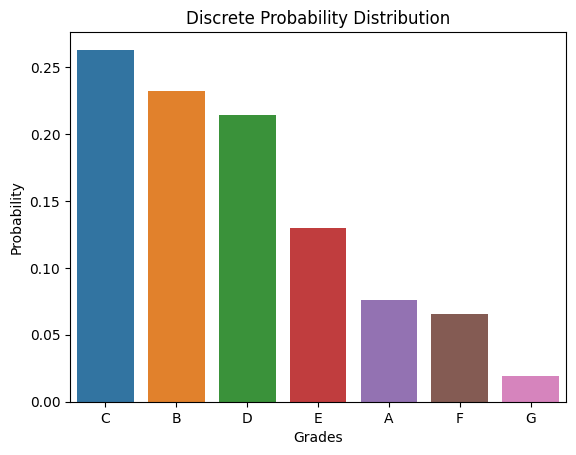

In [30]:
import seaborn as sns

df_charged_off = df_loss_indication[df_loss_indication['loan_status'].isin(['Charged Off'])]

grade_probs = df_charged_off['grade'].value_counts(normalize=True)

dpd = sns.barplot(y=grade_probs.values, x=grade_probs.index)

plt.xlabel('Grades')
plt.ylabel('Probability')
plt.title('Discrete Probability Distribution')
plt.show()

We can clearly see a major bias towards the grades C, B, and D here. We can't paint the whole picture from just a single graph, so let's look at the other highlighted columns too.

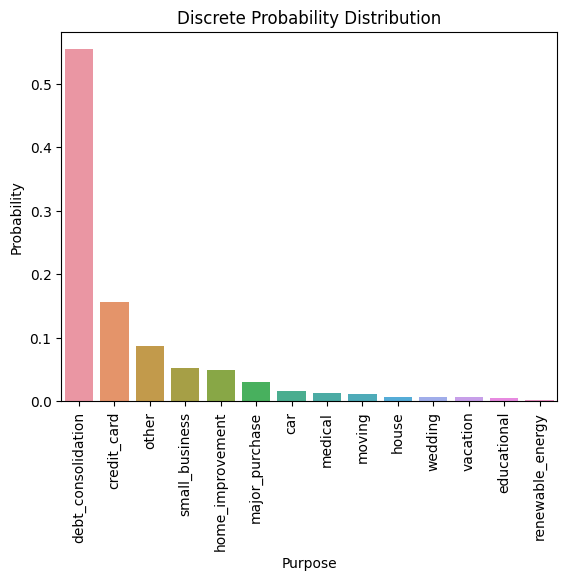

In [35]:
purpose_probs = df_charged_off['purpose'].value_counts(normalize=True)

dpd = sns.barplot(y=purpose_probs.values, x=purpose_probs.index)
plt.xticks(rotation=90)
plt.xlabel('Purpose')
plt.ylabel('Probability')
plt.title('Discrete Probability Distribution')
plt.show()

Now we can see a clearer image of the types of loans that are charged off. Loans with a purpose of debt consolidation are far more likely to not pay off a loan, which is hardly a surprisingly outcome here. Let's keep looking through the columns!

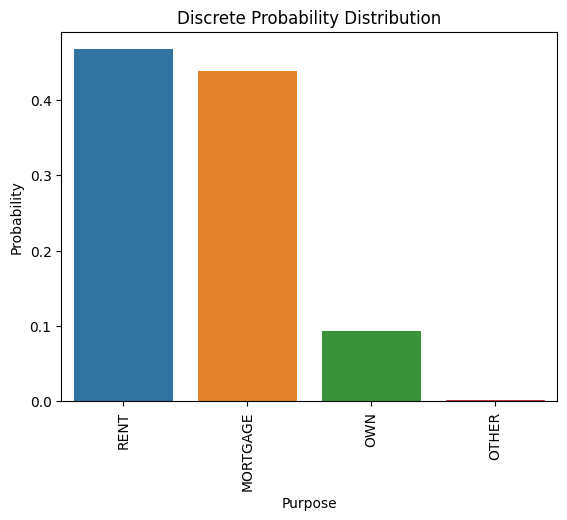

In [36]:
purpose_probs = df_charged_off['home_ownership'].value_counts(normalize=True)

dpd = sns.barplot(y=purpose_probs.values, x=purpose_probs.index)
plt.xticks(rotation=90)
plt.xlabel('Home Ownership')
plt.ylabel('Probability')
plt.title('Discrete Probability Distribution')
plt.show()

People who own their home are naturally likely to have a more stable income and be less likely to pay off a loan, but there does not seem to be a hige difference between people who rent and people mortgage. Let's continue to look at the remaining columns before making any inferences.

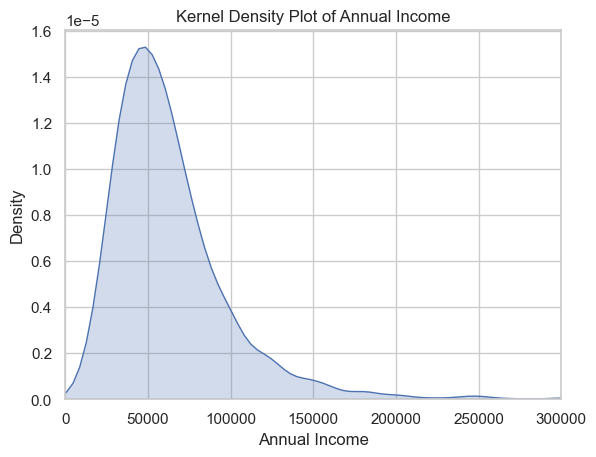

64464.38465149073
55980.0


In [51]:
# Create a kernel density plot

sns.set(style="whitegrid")

sns.kdeplot(df_charged_off['annual_inc'], fill=True)

mean_value = df_charged_off['annual_inc'].mean()
median_value = df_charged_off['annual_inc'].median()

plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Annual Income')

plt.xlim(0, right=300000)

# Show the plot
plt.show()

mean = df_charged_off['annual_inc'].mean()
median = df_charged_off['annual_inc'].median()